## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random

## Function that reads the data

In [2]:
def get_data():
    # Path which our data is stored
    path = 'dns_oct-jan.csv'

    data = pd.read_csv(
             path,
             header=0
    )

    # Change to data type to datetime
    data['day'] = pd.to_datetime(data.day)

    # Keep necessary columns
    data = data[['shieldid', 'day', 'dns_qname', 'dns_qdomainname', 'num_clients', 'num_responses']]
    
    # drop the test shieldid
    bad_shield = 'haddomyev'
    data = data[data.shieldid != bad_shield]
    
    return data

In [3]:
data = get_data()

## Function transforms data into df

In [4]:
def get_df(data):    
    
    # df1 sums by domain name and day
    df1 = data.groupby(by=['dns_qdomainname','day']).sum()

    # df2 counts unique query names by domain name and day
    df2 = data.groupby(by=['dns_qdomainname','day'])[['shieldid','dns_qname']].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'shieldid': 'num_shieldid', 'dns_qname': 'num_dns_qname'}, inplace=True)
    
    # Concatenate df1 and df2 into df
    df = pd.concat([df1, df2], axis=1)
    df.reset_index(level=1, inplace=True)
    
    # Create Column with Generic popularity
    path = 'https://raw.githubusercontent.com/zer0h/top-1000000-domains/master/top-1000000-domains'
    top_domains = pd.read_csv(path, header=None, names=['dns_qdomainname'])
    rank = list(range(1, 1_000_001))
    top_domains['rank'] = rank
    top_domains.set_index('dns_qdomainname',inplace=True)
    df = df.join(top_domains, on='dns_qdomainname')
    
    # Merge with the transformed whois csv
    import re
    whois = pd.read_csv('whoisv1.csv')
    whois.set_index('domain', inplace=True)
    dfmerged = df.join(whois, on='dns_qdomainname')
    
    # Define data types
    dfmerged['registration_period'] = pd.to_numeric(dfmerged['registration_period'].str.replace(r'\D+', '', regex=True))
    dfmerged['day'] = pd.to_datetime(dfmerged['day'])
    dfmerged['created'] = pd.to_datetime(dfmerged['created'])
    dfmerged['updated'] = pd.to_datetime(dfmerged['updated'])
    dfmerged['expires'] = pd.to_datetime(dfmerged['expires'])
    
    return dfmerged

df = get_df(data)

In [5]:
df.head(5)

,day,num_clients,num_responses,num_shieldid,num_dns_qname,rank,created,updated,expires,whois,registration_period
dns_qdomainname,,,,,,,,,,,
*google.com,2022-10-02,1,2,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-03,1,2,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-04,1,2,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-10,1,1,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-11,3,115,2,1,NaN,NaT,NaT,NaT,NaN,NaN


# Create a PROB_OBS_NUM_CLIENTS column

**Probabilistic approach**
- Group domains with similar total number of client traffic with a client sum group column
- Examine the empirical probability distribution for daily number of clients in each client sum group
    - Ex: When we have domains with daily clients that sum to $7$, the client sum group $7$ has values $s$$S = \{1,2,3,4,5,6,7\}$. We will have an exact probability $p$ of seeing each $s$ in $S$.
- Map the probability of seeing a value as large as $s$ for each client sum group
    - Ex: Client sum group $3$ has $S = \{1,2,3\}$. For each $s$, we map values for $p$ such as $P = \{1,0.2,0.1\}$
- After doing this for all client sum groups, we decide a probability cutoff while considering anomaly sensitivity.
    - Ex: Only taking observations where $p \leq 0.01$ 
## Create a client_sum_group column that puts each observation into a client sum group

In [6]:
# Group by domain and sum the number of clients
clients_by_domain = df.groupby(df.index)['num_clients'].sum().reset_index()

# Sort the clients by ascending order
clients_by_domain.sort_values(by='num_clients', inplace=True)

# Create the bin edges for 5 equal cuts
bin_edges_a = pd.qcut(clients_by_domain['num_clients'], q=clients_by_domain.num_clients.nunique(), duplicates='drop').sort_values().unique()

# Create the bin labels
bin_labels = [f"{int(bin_edges_a[i].left+1)}-{int(bin_edges_a[i].right)}" for i in range(len(bin_edges_a))]

# Convert bin edges to floats
bin_edges = [float(bin_edge.left) for bin_edge in bin_edges_a]
bin_edges.append(float(bin_edges_a[-1].right))

# Bin the data and assign the labels to each row
clients_by_domain['group'] = pd.cut(clients_by_domain['num_clients'], bins=bin_edges, labels=bin_labels)

# Merge the labeled data back to the original dataframe
df = pd.merge(df, clients_by_domain[['dns_qdomainname', 'group']], on='dns_qdomainname', how='left')
df.rename(columns={'group': 'client_sum_group'}, inplace=True)
df.set_index('dns_qdomainname', inplace=True)

In [84]:
print('We have ' + str(df.client_sum_group.nunique()) + ' different client sum groups.')
df[['day', 'num_clients', 'client_sum_group']].sample(5)

We have 318 different client sum groups.


,day,num_clients,client_sum_group
dns_qdomainname,,,
xserver.jp,2022-11-02,12,147-148
ideas4diy.com,2022-10-28,1,3-3
yesmovies.ag,2023-01-23,4,63-63
werthers-original.us,2022-11-23,2,37-37
torrents.to,2022-12-01,1,49-49


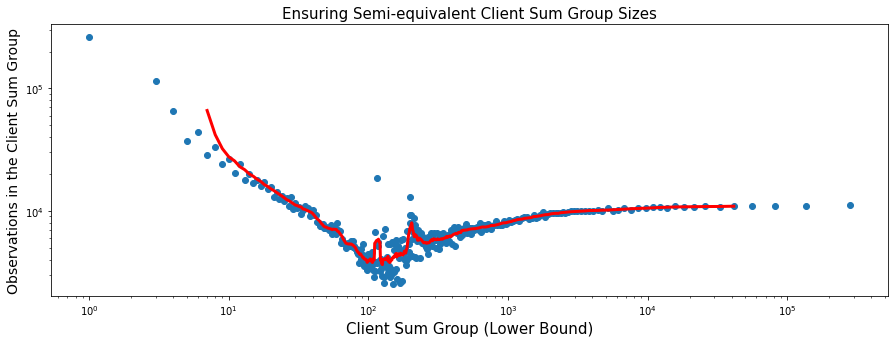

In [8]:
# Plot the number of observations for each sum group
group_counts = df.client_sum_group.value_counts().sort_index()
group_counts.index = group_counts.index.map(lambda x: int(x.split('-')[0]))
plt.figure(figsize=(15,5))
plt.scatter(group_counts.index, group_counts.values)
# Rolling mean of our observation counts
group_counts_rounded = group_counts.rolling(window=10, center=True).mean()
plt.plot(group_counts_rounded.index, group_counts_rounded.values, color='red', linewidth=3)
# Plot details
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Client Sum Group (Lower Bound)', fontsize=15)
plt.ylabel('Observations in the Client Sum Group' , fontsize=14)
plt.title('Ensuring Semi-equivalent Client Sum Group Sizes', fontsize=15)
plt.show()

## Motivation: example with sum_of_clients = '73-73' and the domain 'effusedprankle.com'

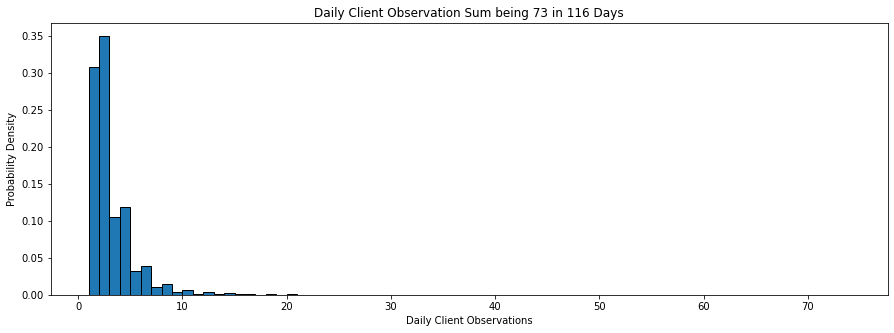

In [32]:
# Sum group 73-73
group = '73-73'
# Number of bins
num_bins = int(group.split('-')[0])+1  
# Locate rows in df with the specified client cum group
test = df.loc[df.client_sum_group==group]
# Plot the histogram
plt.figure(figsize=(15,5))
plt.hist(test.num_clients, bins=np.linspace(1, num_bins, num_bins),
         density=True, edgecolor='black')
# Split the sum group string into two part
parts = group.split('-')
# Check if the first and last characters are the same
if parts[0] == parts[1]:
    group = parts[0]
# Plot details  
plt.xlabel('Daily Client Observations')
plt.ylabel('Probability Density')
plt.title("Daily Client Observation Sum being " + str(group) + ' in ' + str((df.day.max()-df.day.min()).days+1) + ' Days')
plt.show()

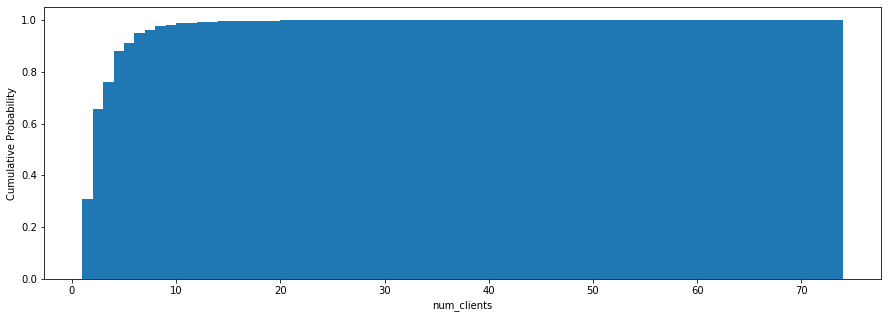

In [33]:
# Plot the cumulative distribution 
plt.figure(figsize=(15,5))
pds, bins, patches = plt.hist(test.num_clients, bins=np.linspace(1, num_bins, num_bins), cumulative=True, density=True)
# Print the list of probability densities
for i in range(len(pds)):
    pds[i] = round(pds[i], 3)
# Plot details
plt.xlabel('num_clients')
plt.ylabel('Cumulative Probability')
plt.show()

In [34]:
# Probability that an observation is greater than or equal to 1, 2, ... sum_of_clients
probs = list(1-pds)
probs.insert(0, 1)
probs.pop(-1)
probs = np.array(probs)
# Daily number of client bins
bins = list(bins)
for i in range(len(bins)):
    bins[i] = int(i)
bins.pop(0)
bins = np.array(bins)
# Probability map
prob_map = pd.DataFrame({'num_clients': bins, 'prob_obs_num_clients': probs})
prob_map

,num_clients,prob_obs_num_clients
0,1,1.000
1,2,0.693
2,3,0.343
3,4,0.238
4,5,0.120
...,...,...
68,69,0.000
69,70,0.000
70,71,0.000
71,72,0.000


In [35]:
# Number of clients probability dictionary
client_dict = dict(zip(bins, probs))
# Create our column with probabiities
test['prob_obs_num_clients'] = test['num_clients'].map(client_dict)
# List of domains that have an anomaly
cutoff = 0.01
anomalies = list(test.loc[test.prob_obs_num_clients<=cutoff].sort_values(by='num_clients', ascending=False).index.unique())

/var/folders/71/xfbtbhlj7376x9dz94q5nmbh0000gn/T/ipykernel_31689/3710457374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prob_obs_num_clients'] = test['num_clients'].map(client_dict)


In [38]:
test.loc[test.prob_obs_num_clients<=cutoff].sort_values(by='num_clients', ascending=False).head(5)

,day,num_clients,num_responses,num_shieldid,num_dns_qname,rank,created,updated,expires,whois,registration_period,client_sum_group,prob_obs_num_clients
dns_qdomainname,,,,,,,,,,,,,
christiansunite.com,2022-11-10,68,186,2,23,149406.0,1999-06-28,1999-06-28,2023-06-28,whois.networksolutions.com,8766.0,73-73,0.000
adelphi.edu,2022-10-18,38,46,2,19,66756.0,1990-04-19,1990-04-19,2021-07-31,whois.educause.net,11426.0,73-73,0.000
jkcf.org,2022-10-11,32,68,2,2,129943.0,2000-12-11,2000-12-11,2022-12-11,whois.networksolutions.com,8035.0,73-73,0.001
creativelive.com,2022-10-12,28,96,2,7,10172.0,2008-12-31,2008-12-31,2023-12-31,whois.namecheap.com,5478.0,73-73,0.001
effusedprankle.com,2022-10-03,26,623,4,1,NaN,2022-02-27,2022-02-27,2023-02-27,whois.pananames.com,365.0,73-73,0.001


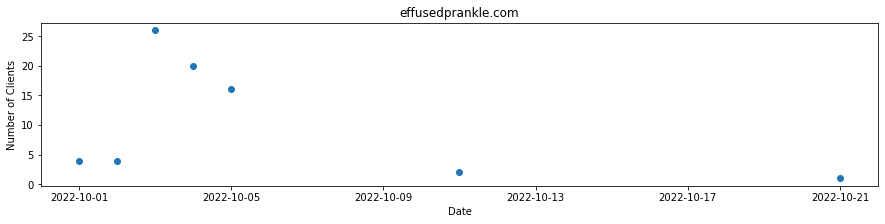

In [14]:
# Effusedprankle.com detected as anomaly
case = 'effusedprankle.com'
testcase = test.loc[test.index==case]
plt.figure(figsize=(15,3))
plt.scatter(x=testcase.day, y=testcase.num_clients)
plt.title(case)
plt.xlabel('Date')
plt.ylabel('Number of Clients')
plt.show()

<img src="spam_example1.png" width="500">

## Creating the column called 'prob_obs_num_clients'

In [86]:
import time

start_time = time.time()

# list the sum groups
sum_groups = list(df.client_sum_group.sort_values().unique())

# loop over each client_sum_group
for group in sum_groups:
    # empty dictionary
    client_dict = {}
    # slice the df to sum group
    case = df.loc[df.client_sum_group==group]
    # create the number of bins so we get discrete bins
    num_bins = case.num_clients.max()
    # cumulative distribution of the empirical observations
    pds, bins = np.histogram(case.num_clients, bins=num_bins, density=False)
    probs = list(1 - (pds/np.sum(pds)).cumsum())
    probs.insert(0,1)
    probs.pop(-1)
    probs = np.array(probs)
    # list the integer bin values
    bins = list(bins)
    for i in range(len(bins)):
        bins[i] = int(i)
    bins.pop(0)
    bins = np.array(bins)
    # client dictionary
    client_dict = dict(zip(bins, probs))
    # replace the values in the 'prob_obs_num_clients' column with dictionary values
    df.loc[df['client_sum_group'] == group, 'prob_obs_num_clients'] = case['num_clients'].map(client_dict)
    
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 4.184468984603882 seconds


# ANOMALIES

In [87]:
# Random sample from the top 1000
(df.sort_values(by='prob_obs_num_clients').head(1000).sample(10))[['day', 'num_clients', 'rank', 'registration_period', 'client_sum_group', 'prob_obs_num_clients']]
# Check 'prreqcroab.icu'

,day,num_clients,rank,registration_period,client_sum_group,prob_obs_num_clients
dns_qdomainname,,,,,,
tbs.com,2022-10-18,183,73041.0,9862.0,500-510,0.000256
band.us,2023-01-17,134,4451.0,7669.0,1936-2010,0.000531
smithsonianmag.com,2022-10-11,297,5064.0,9495.0,2681-2801,0.000307
middlesexcountynj.gov,2022-11-02,188,NaN,NaN,1085-1120,0.000480
vulture.com,2022-10-03,303,2538.0,7670.0,2950-3124,0.000303
sifee.biz,2022-10-26,44,NaN,3286.0,44-44,0.000127
thecut.com,2022-10-21,181,NaN,9496.0,1159-1203,0.000232
appetize.io,2022-10-15,40,123596.0,3287.0,40-40,0.000199
willistowerswatson.com,2022-11-28,57,NaN,2922.0,176-178,0.000339


### When the client_sum_group is small, we have a small sample space for potential num_clients. For example, in client_sum_group '3-3', our sample space for potential num_clients observations is {1, 2, 3}. When this happens, our model does not have enough granularity. Thus randomness comes into play whether a daily observation is persay a '1' or a '2' and whether a domain is categorized persay in client_sum_group '3-3' or '4-4'.

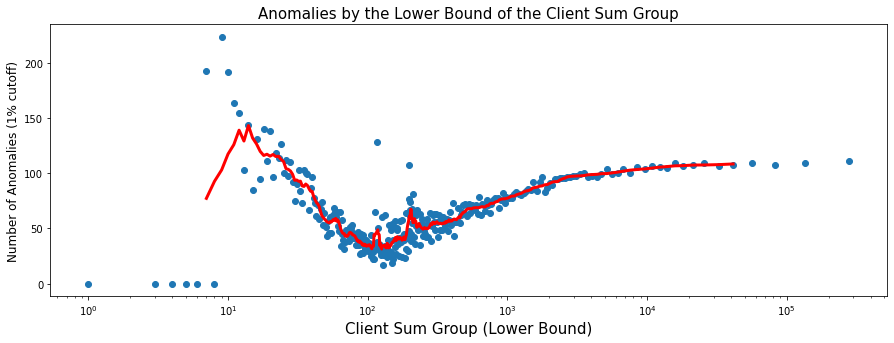

In [88]:
# Choosing an anomaly as less than 1% probability across the board
cutoff = .01
anomalies = df.loc[(df.prob_obs_num_clients<=cutoff)].client_sum_group.value_counts().sort_index()
anomalies.index = anomalies.index.map(lambda x: int(x.split('-')[0]))
plt.figure(figsize=(15,5))
plt.scatter(anomalies.index, anomalies.values)
anomalies_rounded = anomalies.rolling(window=10, center=True).mean()
plt.plot(anomalies_rounded.index, anomalies_rounded.values, color='red', linewidth=3)
plt.xscale('log')
plt.xlabel('Client Sum Group (Lower Bound)', fontsize=15)
plt.ylabel('Number of Anomalies (' + str(round(cutoff*100)) + '% cutoff)', fontsize=12)
plt.title('Anomalies by the Lower Bound of the Client Sum Group', fontsize=15)
plt.show()

### However, recall that the number of observations in each client sum group was also imbalanced. Given the chosen cutoff, examine the proportion of anomalies per client sum group. The proportion of anomalies per client sum group approaches our desired cutoff as the client sum group gets larger. As we increase our client sum group, our sample space for potential num_clients observations gets larger. Increased granularity in the probability space results in increased anomaly capture.

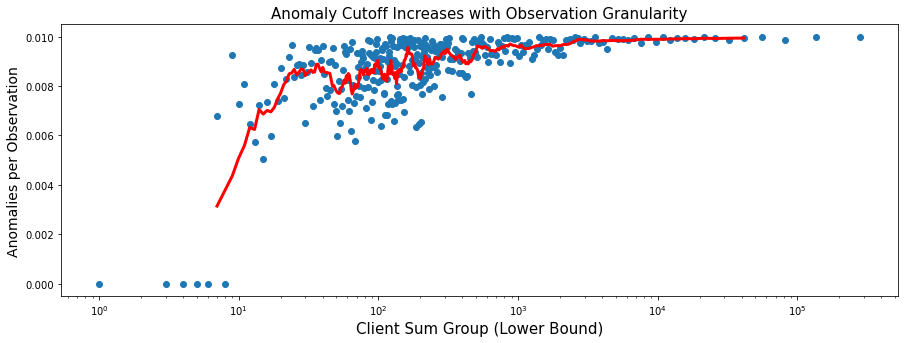

In [90]:
# Plot the number of observations for each sum group
group_counts = df.client_sum_group.value_counts().sort_index()
group_counts.index = group_counts.index.map(lambda x: int(x.split('-')[0]))
granularity = (anomalies/group_counts)
granularity_rounded = granularity.rolling(window=10, center=True).mean()
plt.figure(figsize=(15,5))
plt.scatter(granularity.index, granularity.values)
plt.plot(granularity_rounded.index, granularity_rounded.values, color='red', linewidth=3)
plt.xscale('log')
plt.xlabel('Client Sum Group (Lower Bound)', fontsize=15)
plt.ylabel('Anomalies per Observation' , fontsize=14)
plt.title('Anomaly Cutoff Increases with Observation Granularity', fontsize=15)
plt.show()

# Create a PROB_OBS_NUM_RESPONSES column

# Create a PROB_OBS_NUM_SHIELDIDS column

# Create a PROB_OBS_NUM_DNS_QNAMES column

## We have identified a probabilistic approach with a "clouded lens", but we want to know what other factors are when it comes to an anomaly. We could define an anomaly column of 0 (False) or 1 (True) by mutliplying each of the PROB columns. We would play around with the cutoff value based on how sensitive we want our model to be detecting anomalies. 

## Then, once we have labeled each observation, we would be able to improve the model with machine learning on the PROB columns, rank, top level domain, registration period, day, etc.

## Parameters could yield valuable information in identifying and improving the proposed anomaly detection method and provide us with a "clear lens".

## Plotting the anomalies

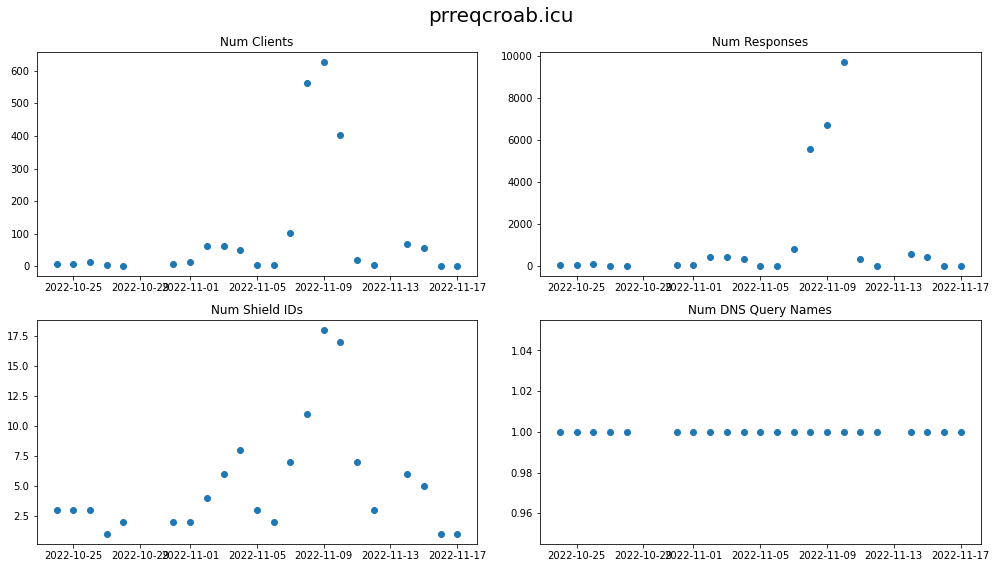

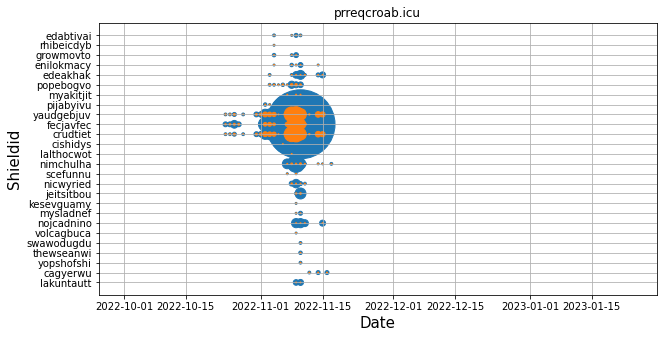

In [67]:
domain = 'prreqcroab.icu'
test = df.loc[df.index==domain]

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[(0,0)].scatter(test.day, test.num_clients)
axs[(0,0)].set_title('Num Clients')

axs[(0,1)].scatter(test.day, test.num_responses)
axs[(0,1)].set_title('Num Responses')

axs[(1,0)].scatter(test.day, test.num_shieldid)
axs[(1,0)].set_title('Num Shield IDs')

axs[(1,1)].scatter(test.day, test.num_dns_qname)
axs[(1,1)].set_title('Num DNS Query Names')

plt.suptitle(str(domain), fontsize=20)
plt.tight_layout()
plt.show()

def get_domain_case_new(data, domain_name):    
    
    datatemp = data.loc[data.dns_qdomainname==domain_name]
    
    # df1 sums by domain name and day
    df1 = datatemp.groupby(by=['dns_qdomainname','day','shieldid']).sum()

    # df2 counts unique query names by domain name and day
    df2 = datatemp.groupby(by=['dns_qdomainname','day','shieldid'])['dns_qname'].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'dns_qname': 'num_dns_qname'}, inplace=True)

    # Concatenate df1 and df2 into df
    domain_case_new = pd.concat([df1, df2], axis=1)
    domain_case_new.reset_index(level=1, inplace=True)
    domain_case_new.reset_index(level=1, inplace=True)
    
    from itertools import product

    # Create lists of all unique values in columns 
    l1 = [domain_name]
    l2 = list(data.day.unique())
    l3 = list(domain_case_new.shieldid.unique())
    l4 = [0]
    l5 = [0]
    l6 = [0]

    _ = pd.DataFrame(list(product(l1, l2, l3, l4, l5, l6)), columns=['dns_qdomainname', 'day', 'shieldid', 'num_clients', 'num_responses', 'num_dns_qname'])
    _.set_index(list(_)[0], inplace=True)

    domain_case_new = pd.concat([domain_case_new, _])

    domain_case_new = domain_case_new.sort_values('day')

    return domain_case_new

domain_case_new = get_domain_case_new(data, domain)

# Plot
plt.figure(figsize=(10,5))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Shieldid', fontsize=15)
plt.title(domain)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_responses)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_clients)
plt.grid(axis='both')